# Residual Multi-Modal Regression using Tabular Features and Satellite Image Embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Environment Setup & Dependencies
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Tabular Data Preprocessing

In [ ]:
BASE = "/content/drive/MyDrive/satellite_property"
df = pd.read_excel(f"{BASE}/data/raw/train.xlsx")

TARGET = "price"

df["log_price"] = np.log(df[TARGET]) #LOG TRANSFORM

#Keep id for image mapping
house_ids = df["id"].astype(str).values

# Remove non-tabular columns
df = df.drop(columns=[TARGET, "id", "date", "zipcode"])

In EDA ,House prices exhibit heavy **right skewness**. Applying a **logarithmic transformation** stabilizes variance, reduces the influence of extreme values, and improves regression performance.

In [ ]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols.remove("log_price")

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

X = df.drop(columns=["log_price"])
y = df["log_price"].values

X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X, y, house_ids,
    test_size=0.2,
    random_state=42
)

Numerical columns: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Categorical columns: []


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

xgb_tabular = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_tabular.fit(X_train, y_train)

y_pred = xgb_tabular.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

results_xgb = pd.DataFrame({
    "Model": ["XGBoost (Tabular Only)"],
    "MAE": [mae],
    "RMSE": [rmse],
    "R2": [r2]
})

results_xgb


Model       MAE      RMSE        R2
0  XGBoost (Tabular Only)  0.117545  0.163854  0.902708

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

input_dim = X_train_proc.shape[1]

The dataset contains no missing values, so imputation is not required, and all features are numerical with no categorical variables present. Therefore, only **standardization (StandardScaler)** is applied to normalize feature scales and ensure stable and efficient model training.

In [ ]:
from torchvision import models, transforms
from PIL import Image
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision import models
import torch.nn as nn

inception = models.inception_v3(
    weights=models.Inception_V3_Weights.IMAGENET1K_V1
)

inception.fc = nn.Identity()
inception.AuxLogits.fc = nn.Identity()

inception.eval().to(device)

for p in inception.parameters():
    p.requires_grad = False


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 178MB/s] 


In [ ]:
img_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),   # values in [0,1]
])

In [ ]:
# Image data loading
IMAGE_DIR = "/content/drive/MyDrive/satellite_property/data/images/train"

def build_image_path_dict(image_dir):
    """
    Returns: {house_id: image_path}
    """
    img_map = {}
    for fname in os.listdir(image_dir):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            house_id = fname.split(".")[0]
            img_map[house_id] = os.path.join(image_dir, fname)
    return img_map
image_path_dict = build_image_path_dict(IMAGE_DIR)
print("Total images found:", len(image_path_dict))


Total images found: 16110


In [ ]:
def extract_embeddings_batched(
    image_path_dict,
    batch_size=32
):
    image_embeddings = {}

    ids = list(image_path_dict.keys())

    for i in tqdm(range(0, len(ids), batch_size), desc="Extracting embeddings"):
        batch_ids = ids[i:i + batch_size]
        batch_imgs = []

        for hid in batch_ids:
            img = Image.open(image_path_dict[hid]).convert("RGB")
            img = img_transform(img)
            batch_imgs.append(img)

        batch_imgs = torch.stack(batch_imgs).to(device)

        with torch.no_grad():
            emb = inception(batch_imgs)  # (B, 2048)

        emb = emb.cpu().numpy()

        for j, hid in enumerate(batch_ids):
            image_embeddings[hid] = emb[j]

    return image_embeddings


This function loads satellite images in batches, applies the required transformations, and passes them through a pretrained Inception model to extract fixed-length feature embeddings. Batch-wise processing reduces memory usage and speeds up computation, while disabling gradients ensures efficient inference-only execution.

In [ ]:
from tqdm.notebook import tqdm
image_embeddings = extract_embeddings_batched(
    image_path_dict,
    batch_size=32  # ideal for T4
)
np.save("/content/drive/MyDrive/satellite_property/image_embeddings.npy", image_embeddings)
print("Saved embeddings:", len(image_embeddings))

Extracting embeddings:   0%|          | 0/504 [00:00<?, ?it/s]

Saved embeddings: 16110


In [ ]:
missing = [i for i in ids_train if i not in image_embeddings]
print("Missing image embeddings:", len(missing))
print("Example missing ID:", missing[:5])


Missing image embeddings: 0
Example missing ID: []


In [ ]:
from scipy.sparse import issparse
from torch.utils.data import Dataset

class FusionDataset(Dataset):
    def __init__(self, X_tab, ids, y, image_embeddings):
        if issparse(X_tab):
            X_tab = X_tab.toarray()

        self.X_tab = torch.tensor(X_tab, dtype=torch.float32)
        self.X_img = torch.tensor(
            np.vstack([image_embeddings[i] for i in ids]),
            dtype=torch.float32
        )
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_tab[idx], self.X_img[idx], self.y[idx]

In [ ]:
image_embeddings = np.load(
    "/content/drive/MyDrive/satellite_property/image_embeddings.npy",
    allow_pickle=True
).item()

for k in image_embeddings:
    v = image_embeddings[k]
    image_embeddings[k] = v / np.linalg.norm(v)

train_ds = FusionDataset(
    X_train_proc, ids_train, y_train, image_embeddings
)

val_ds = FusionDataset(
    X_val_proc, ids_val, y_val, image_embeddings
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

In [ ]:
class TabularFCNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


class ImageHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


class TabularHead(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 40),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


class FusionRegressor(nn.Module):
    def __init__(self, tab_input_dim):
        super().__init__()
        self.image_head = ImageHead()
        self.tabular_head = TabularHead(tab_input_dim)
        self.regressor = nn.Linear(64 + 40, 1)

    def forward(self, x_tab, x_img):
        img_feat = self.image_head(x_img)
        tab_feat = self.tabular_head(x_tab)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(fused).squeeze(1)


In [ ]:
tab_model = TabularFCNet(X_train_proc.shape[1]).to(device)

In [ ]:
optimizer_tab = torch.optim.Adam(tab_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(198):
    tab_model.train()
    total_loss = 0

    for x_tab, _, y in train_loader:
        x_tab, y = x_tab.to(device), y.to(device)

        optimizer_tab.zero_grad()
        y_pred = tab_model(x_tab)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer_tab.step()

        total_loss += loss.item()

    print(f"[Tab] Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


[Tab] Epoch 1 | Loss: 36.8554
[Tab] Epoch 2 | Loss: 1.4444
[Tab] Epoch 3 | Loss: 1.2796
[Tab] Epoch 4 | Loss: 1.2055
[Tab] Epoch 5 | Loss: 1.1324
[Tab] Epoch 6 | Loss: 1.0697
[Tab] Epoch 7 | Loss: 1.0388
[Tab] Epoch 8 | Loss: 0.9833
[Tab] Epoch 9 | Loss: 0.9611
[Tab] Epoch 10 | Loss: 0.9272
[Tab] Epoch 11 | Loss: 0.9020
[Tab] Epoch 12 | Loss: 0.8739
[Tab] Epoch 13 | Loss: 0.8408
[Tab] Epoch 14 | Loss: 0.8149
[Tab] Epoch 15 | Loss: 0.8321
[Tab] Epoch 16 | Loss: 0.7872
[Tab] Epoch 17 | Loss: 0.7846
[Tab] Epoch 18 | Loss: 0.7383
[Tab] Epoch 19 | Loss: 0.7611
[Tab] Epoch 20 | Loss: 0.7146
[Tab] Epoch 21 | Loss: 0.6971
[Tab] Epoch 22 | Loss: 0.6904
[Tab] Epoch 23 | Loss: 0.6781
[Tab] Epoch 24 | Loss: 0.6788
[Tab] Epoch 25 | Loss: 0.6738
[Tab] Epoch 26 | Loss: 0.6557
[Tab] Epoch 27 | Loss: 0.6439
[Tab] Epoch 28 | Loss: 0.6313
[Tab] Epoch 29 | Loss: 0.6246
[Tab] Epoch 30 | Loss: 0.5943
[Tab] Epoch 31 | Loss: 0.6002
[Tab] Epoch 32 | Loss: 0.5803
[Tab] Epoch 33 | Loss: 0.5773
[Tab] Epoch 34 | L

In [ ]:
tab_model.eval()
for p in tab_model.parameters():
    p.requires_grad = False

In [ ]:
fusion_model = FusionRegressor(X_train_proc.shape[1]).to(device)

In [ ]:

from sklearn.metrics import r2_score
import numpy as np

criterion = nn.MSELoss()
optimizer_fusion = torch.optim.Adam(fusion_model.parameters(), lr=5e-4, weight_decay = 1e-4)

for epoch in range(200):
    # ---------- TRAIN ----------
    fusion_model.train()
    train_loss = 0.0

    for x_tab, x_img, y in train_loader:
        x_tab = x_tab.to(device)
        x_img = x_img.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_tab = tab_model(x_tab)
            residual = y - y_tab

        optimizer_fusion.zero_grad()
        r_pred = fusion_model(x_tab, x_img)
        loss = criterion(r_pred, residual)
        loss.backward()
        optimizer_fusion.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---------- VALIDATION (R² on FINAL prediction) ----------
    fusion_model.eval()
    val_preds, val_targets = [], []

    with torch.no_grad():
        for x_tab, x_img, y in val_loader:
            x_tab = x_tab.to(device)
            x_img = x_img.to(device)

            y_tab = tab_model(x_tab)
            r_pred = fusion_model(x_tab, x_img)

            y_final = y_tab + r_pred

            val_preds.append(y_final.cpu())
            val_targets.append(y)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_r2 = r2_score(val_targets, val_preds)

    print(
        f"[Epoch {epoch+1:02d}] "
        f"Fusion Train Loss: {train_loss:.4f} | "
        f"Val R² (FINAL): {val_r2:.4f}"
    )


[Epoch 01] Fusion Train Loss: 0.0368 | Val R² (FINAL): 0.8808
[Epoch 02] Fusion Train Loss: 0.0300 | Val R² (FINAL): 0.8828
[Epoch 03] Fusion Train Loss: 0.0285 | Val R² (FINAL): 0.8838
[Epoch 04] Fusion Train Loss: 0.0279 | Val R² (FINAL): 0.8821
[Epoch 05] Fusion Train Loss: 0.0267 | Val R² (FINAL): 0.8809
[Epoch 06] Fusion Train Loss: 0.0262 | Val R² (FINAL): 0.8792
[Epoch 07] Fusion Train Loss: 0.0256 | Val R² (FINAL): 0.8818
[Epoch 08] Fusion Train Loss: 0.0248 | Val R² (FINAL): 0.8811
[Epoch 09] Fusion Train Loss: 0.0246 | Val R² (FINAL): 0.8816
[Epoch 10] Fusion Train Loss: 0.0239 | Val R² (FINAL): 0.8808
[Epoch 11] Fusion Train Loss: 0.0233 | Val R² (FINAL): 0.8791
[Epoch 12] Fusion Train Loss: 0.0230 | Val R² (FINAL): 0.8773
[Epoch 13] Fusion Train Loss: 0.0229 | Val R² (FINAL): 0.8813
[Epoch 14] Fusion Train Loss: 0.0222 | Val R² (FINAL): 0.8771
[Epoch 15] Fusion Train Loss: 0.0217 | Val R² (FINAL): 0.8784
[Epoch 16] Fusion Train Loss: 0.0217 | Val R² (FINAL): 0.8771
[Epoch 1

In [ ]:
def predict_final(tab_model, fusion_model, loader):
    tab_model.eval()
    fusion_model.eval()

    preds, targets = [], []

    with torch.no_grad():
        for x_tab, x_img, y in loader:
            x_tab = x_tab.to(device)
            x_img = x_img.to(device)

            y_tab = tab_model(x_tab)
            r_pred = fusion_model(x_tab, x_img)

            y_final = y_tab + r_pred

            preds.append(y_final.cpu())
            targets.append(y)

    preds = torch.cat(preds).numpy()
    targets = torch.cat(targets).numpy()
    return preds, targets


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

preds, targets = predict_final(tab_model, fusion_model, val_loader)

rmse = np.sqrt(mean_squared_error(targets, preds))
r2 = r2_score(targets, preds)

print("Final RMSE:", rmse)
print("Final R2:", r2)

Final RMSE: 0.18669035069115728
Final R2: 0.8736993670463562


In [ ]:
# Save only the weights (recommended)
torch.save(fusion_model.state_dict(), "/content/drive/MyDrive/satellite_property/fusion_model.pth")


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming 'price' is your target column in your training dataframe (df)
scaler_y = StandardScaler()
scaler_y.fit(df[['log_price']])

StandardScaler()

In [ ]:
import joblib
joblib.dump(scaler_y, "/content/drive/MyDrive/satellite_property/price_scaler.pkl")

['/content/drive/MyDrive/satellite_property/price_scaler.pkl']

### **GRAD CAM**


--- Top 10 Expensive Houses ---


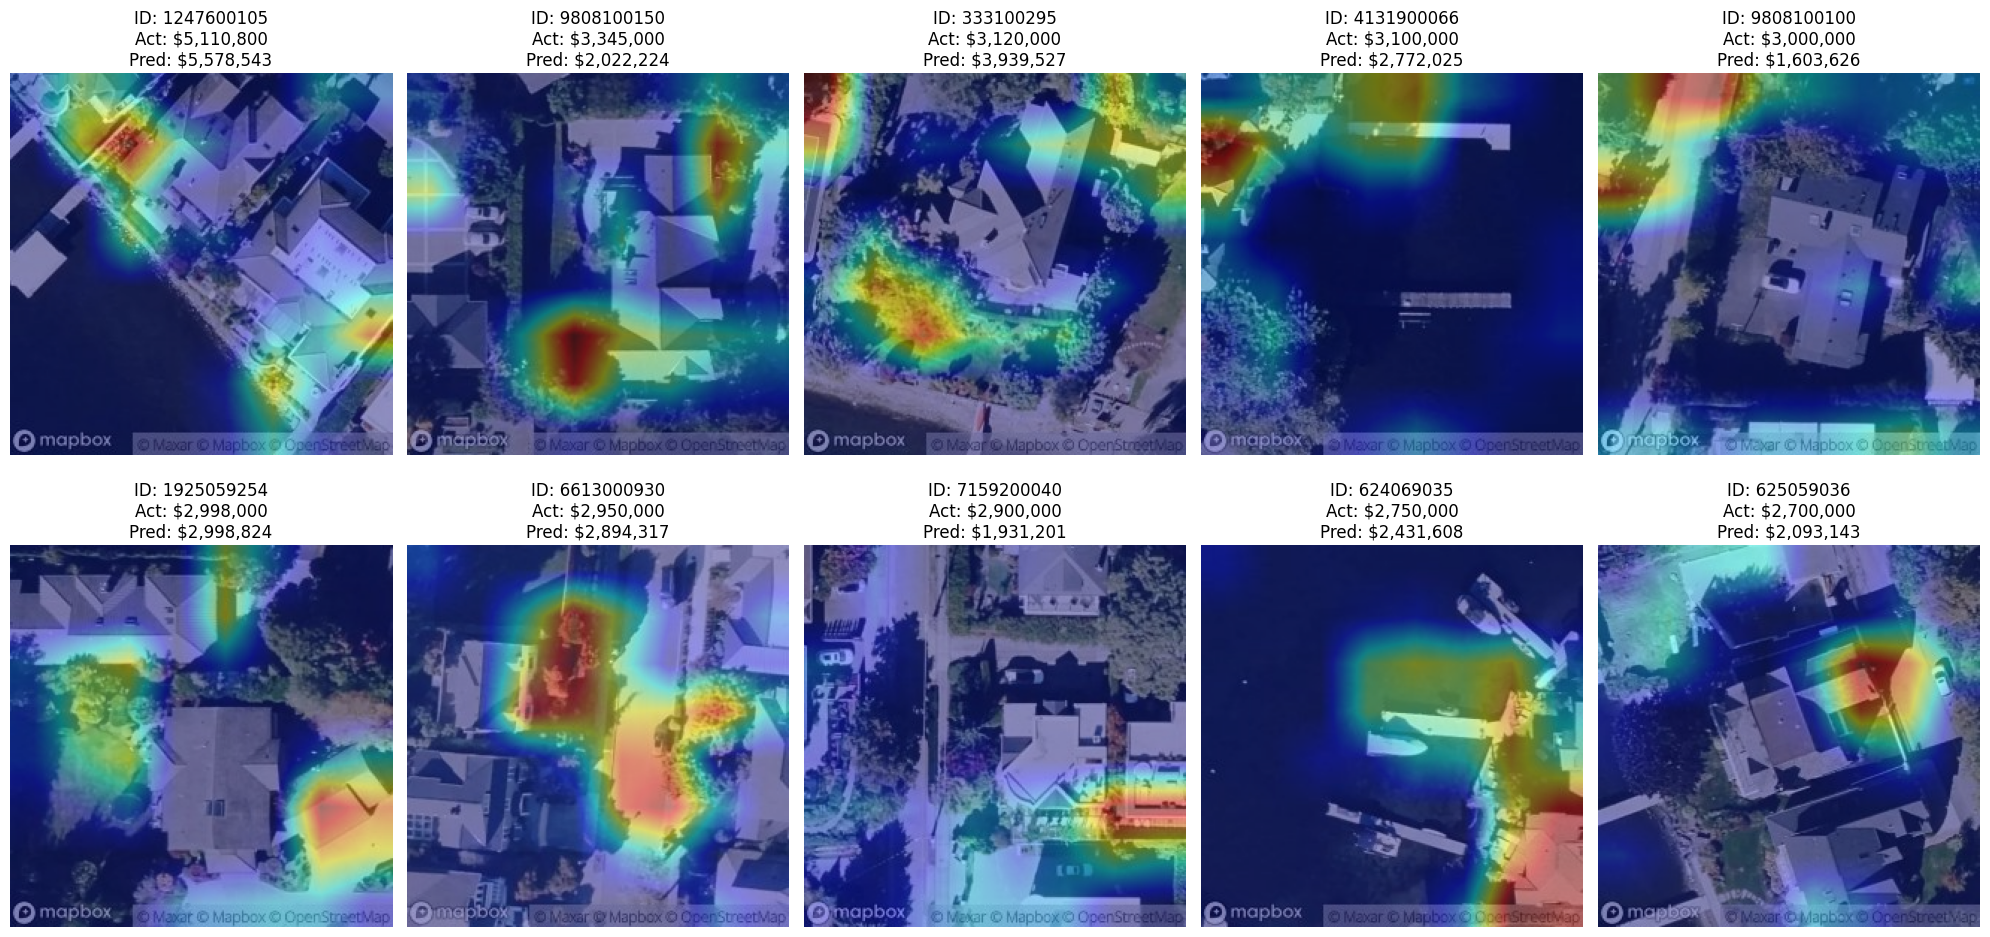


--- Bottom 10 Cheapest Houses ---


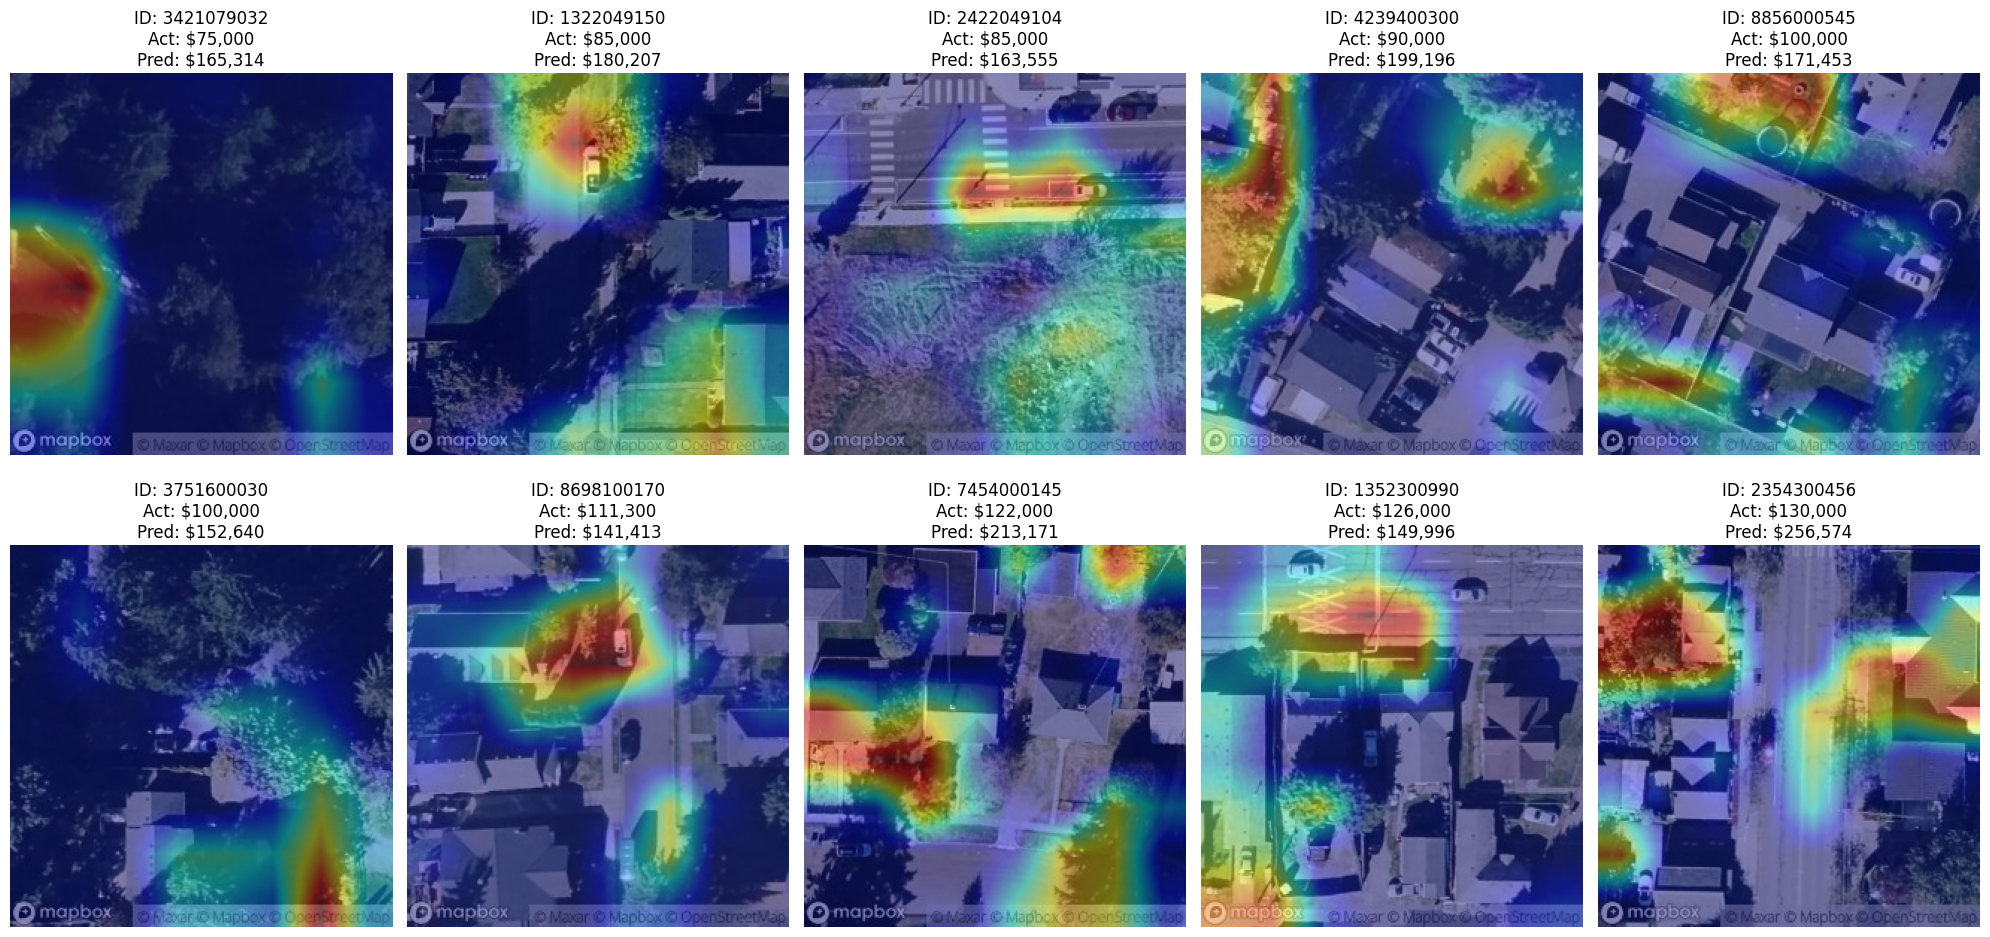

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 1. SETUP THE WRAPPER ---
# This wrapper links Inception and your Fusion model for gradient flow
class GradCamWrapper(nn.Module):
    def __init__(self, inception, tab_model, fusion_model):
        super().__init__()
        self.inception = inception
        self.tab_model = tab_model
        self.fusion_model = fusion_model
        self.gradients = None
        self.activations = None

    def save_gradients(self, grad):
        self.gradients = grad

    def forward(self, x_tab, x_img):
        # We hook into Mixed_7c (the last conv layer of InceptionV3)
        # To do this cleanly, we'll manually step through or use a hook
        # For simplicity in this script, we'll assume the hooks are registered externally

        # Get Inception embedding (2048 vector)
        img_emb = self.inception(x_img)

        # Apply the L2 normalization you used during training
        img_emb_norm = F.normalize(img_emb, p=2, dim=1)

        # Predicted price = Tabular Prediction + Fusion Residual
        with torch.no_grad():
            y_tab = self.tab_model(x_tab)

        r_pred = self.fusion_model(x_tab, img_emb_norm)
        return y_tab + r_pred

# --- 2. GRAD-CAM CORE FUNCTION ---
def generate_visual_explanation(wrapper, x_tab, x_img, original_image):
    wrapper.eval()

    # 1. Register Hooks for the target layer (Mixed_7c)
    def hook_feature(module, input, output):
        wrapper.activations = output
    def hook_gradient(module, grad_in, grad_out):
        wrapper.gradients = grad_out[0]

    target_layer = wrapper.inception.Mixed_7c
    h1 = target_layer.register_forward_hook(hook_feature)
    h2 = target_layer.register_full_backward_hook(hook_gradient)

    # 2. Forward pass
    price_pred = wrapper(x_tab, x_img)

    # 3. Backward pass to get gradients
    wrapper.zero_grad()
    price_pred.backward()

    # 4. Compute Grad-CAM Heatmap
    # Average the gradients over the spatial dimensions
    weights = torch.mean(wrapper.gradients, dim=(2, 3), keepdim=True)
    # Weighted sum of feature maps
    cam = torch.sum(weights * wrapper.activations, dim=1).squeeze()

    # Process heatmap (ReLU and Normalize)
    cam = np.maximum(cam.detach().cpu().numpy(), 0)
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Cleanup hooks
    h1.remove()
    h2.remove()

    return cam, price_pred.item()

# --- 3. MAIN VISUALIZATION LOOP ---
def run_visual_analysis(tab_model, fusion_model, ids_val, X_val_proc, y_val, image_path_dict):
    # Prepare Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load backbone (make sure it's trainable for Grad-CAM)
    inception_backbone = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
    inception_backbone.fc = nn.Identity()
    inception_backbone.to(device)
    for param in inception_backbone.parameters():
        param.requires_grad = True

    model_viz = GradCamWrapper(inception_backbone, tab_model, fusion_model).to(device)

    # Get Indices for Top 10 and Bottom 10 prices
    sorted_indices = np.argsort(y_val)
    bottom_10_indices = sorted_indices[:10]
    top_10_indices = sorted_indices[-10:][::-1] # Reverse for highest first

    groups = [("Top 10 Expensive Houses", top_10_indices),
              ("Bottom 10 Cheapest Houses", bottom_10_indices)]

    for group_name, indices in groups:
        print(f"\n--- {group_name} ---")
        plt.figure(figsize=(20, 10))

        for i, idx in enumerate(indices):
            house_id = ids_val[idx]
            actual_price = np.exp(y_val[idx]) # Convert from log_price if needed

            # Prepare inputs
            img_path = image_path_dict[house_id]
            raw_img = Image.open(img_path).convert("RGB")
            img_tensor = img_transform(raw_img).unsqueeze(0).to(device)
            tab_tensor = torch.tensor(X_val_proc[idx], dtype=torch.float32).unsqueeze(0).to(device)

            # Generate Grad-CAM
            original_img_cv = cv2.imread(img_path)
            original_img_cv = cv2.cvtColor(original_img_cv, cv2.COLOR_BGR2RGB)
            heatmap, pred_price = generate_visual_explanation(model_viz, tab_tensor, img_tensor, original_img_cv)

            # Superimpose
            heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
            heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
            superimposed = cv2.addWeighted(original_img_cv, 0.6, heatmap_color, 0.4, 0)

            # Plot
            plt.subplot(2, 5, i+1)
            plt.imshow(superimposed)
            plt.title(f"ID: {house_id}\nAct: ${actual_price:,.0f}\nPred: ${np.exp(pred_price):,.0f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# --- 4. EXECUTION ---
# Make sure your models and 'img_transform' are defined before running this
run_visual_analysis(tab_model, fusion_model, ids_val, X_val_proc, y_val, image_path_dict)

### Prediction on test dataset

In [ ]:
TEST_PATH = "/content/drive/MyDrive/satellite_property/data/raw/test.xlsx"

df_test = pd.read_excel(TEST_PATH)

print(df_test.shape)
display(df_test.head())

(5404, 20)


id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2591820310  20141006T000000         4       2.25         2070      8893   
1  7974200820  20140821T000000         5       3.00         2900      6730   
2  7701450110  20140815T000000         4       2.50         3770     10893   
3  9522300010  20150331T000000         3       3.50         4560     14608   
4  9510861140  20140714T000000         3       2.50         2550      5376   

   floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0     2.0           0     0          4      8        2070              0   
1     1.0           0     0          5      8        1830           1070   
2     2.0           0     2          3     11        3770              0   
3     2.0           0     2          3     12        4560              0   
4     2.0           0     0          3      9        2550              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1986             0    98058  47.4388 -122.162           2390   
1      1977             0    98115  47.6784 -122.285           2370   
2      1997             0    98006  47.5646 -122.129           3710   
3      1990             0    98034  47.6995 -122.228           4050   
4      2004             0    98052  47.6647 -122.083           2250   

   sqft_lot15  
0        7700  
1        6283  
2        9685  
3       14226  
4        4050

In [ ]:
ID_COL = "id"   # change if column name differs

test_ids = df_test[ID_COL].astype(str).values

X_test_tab = df_test.drop(columns=[ID_COL, "date", "zipcode"], errors="ignore")

# StandardScaler used during training
X_test_tab_scaled = preprocessor.transform(X_test_tab)

X_test_tab_tensor = torch.tensor(
    X_test_tab_scaled,
    dtype=torch.float32
)

In [ ]:
TEST_IMAGE_DIR = "/content/drive/MyDrive/satellite_property/data/images/test"

# Build image path dictionary for test set
image_path_dict_test = build_image_path_dict(TEST_IMAGE_DIR)
print("Total test images found:", len(image_path_dict_test))

# Extract embeddings for test images
test_image_embeddings = extract_embeddings_batched(
    image_path_dict_test,
    batch_size=32  # ideal for T4
)
np.save("/content/drive/MyDrive/satellite_property/test_image_embeddings.npy", test_image_embeddings)
print("Saved test embeddings:", len(test_image_embeddings))

# Normalize test image embeddings
for k in test_image_embeddings:
    v = test_image_embeddings[k]
    test_image_embeddings[k] = v / np.linalg.norm(v)

# Filter out test_ids for which no image embeddings could be found
valid_indices = [idx for idx, i in enumerate(test_ids) if i in test_image_embeddings]
test_ids_filtered = test_ids[valid_indices]
X_test_tab_tensor_filtered = X_test_tab_tensor[valid_indices]

X_test_img = torch.tensor(
    np.vstack([test_image_embeddings[i] for i in test_ids_filtered]),
    dtype=torch.float32
)

Total test images found: 5396


Extracting embeddings:   0%|          | 0/169 [00:00<?, ?it/s]

Saved test embeddings: 5396


In [ ]:
class FusionTestDataset(torch.utils.data.Dataset):
    def __init__(self, X_tab, X_img):
        self.X_tab = X_tab
        self.X_img = X_img

    def __len__(self):
        return len(self.X_tab)

    def __getitem__(self, idx):
        return self.X_tab[idx], self.X_img[idx]

test_dataset = FusionTestDataset(
    X_test_tab_tensor_filtered,
    X_test_img
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [ ]:
# Make sure models are on the correct device and in evaluation mode
tab_model.eval()
fusion_model.eval()

predictions = []

with torch.no_grad():
    for x_tab, x_img in test_loader:
        x_tab = x_tab.to(device)
        x_img = x_img.to(device)

        y_tab = tab_model(x_tab)
        r_pred = fusion_model(x_tab, x_img)

        y_final = y_tab + r_pred

        predictions.extend(y_final.cpu().numpy().ravel())

# INVERSE LOG TRANSFORM
predictions_exp = np.expm1(predictions)

# Save predictions to a CSV
submission_df = pd.DataFrame({
    "id": test_ids_filtered,
    "predicted_price": predictions_exp
})

OUTPUT_PATH = "/content/drive/MyDrive/satellite_property/outputs/fusion_predictions.csv"

submission_df.to_csv(OUTPUT_PATH, index=False)

print("Prediction file saved at:")
print(OUTPUT_PATH)
display(submission_df.head())

Prediction file saved at:
/content/drive/MyDrive/satellite_property/outputs/fusion_predictions.csv


id  predicted_price
0  2591820310     3.810952e+05
1  7974200820     8.103005e+05
2  7701450110     1.112541e+06
3  9522300010     1.786235e+06
4  9510861140     6.984939e+05

In [ ]:
# min or max of price


In [ ]:
min_predicted_price = predictions_exp.min()
max_predicted_price = predictions_exp.max()

print(f"Minimum Predicted Price: ${min_predicted_price:,.2f}")
print(f"Maximum Predicted Price: ${max_predicted_price:,.2f}")

Minimum Predicted Price: $135,164.83
Maximum Predicted Price: $4,895,768.50
